Source of code: https://github.com/patrickvonplaten/notebooks/blob/master/BERT2BERT_for_CNN_Dailymail.ipynb


function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install transformers
!pip install datasets==1.0.2
!pip install pyarrow==0.17.1
#!rm seq2seq_trainer.py
#!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/seq2seq_trainer.py
!cp /content/drive/MyDrive/AML_workshop/seq2seq_trainer.py /content/seq2seq_trainer.py 
!pip install git-python==1.0.3
!pip install sacrebleu==1.4.12
!pip install rouge_score

In [ ]:
import numpy as np
import pandas as pd
#from transformers import AlbertTokenizer
from transformers import BertTokenizerFast, TrainingArguments
from seq2seq_trainer import Seq2SeqTrainer
from sklearn.model_selection import train_test_split
from dataclasses import dataclass, field
from typing import Optional
import tensorflow as tf
from matplotlib import pyplot as plt
import datasets as ds

In [ ]:
"""
# Load data & Split train, val, test sets
train_filename = 'train_set_rest.csv'  # (92608, 3)
train_df = pd.read_csv(path + train_filename)
train_df.columns = ['id', 'FINDINGS', 'IMPRESSION']
test_df = pd.read_csv(path + test_filename)  # 2000
test_df.columns = ['id', 'FINDINGS', 'IMPRESSION']

train_size = train_df.shape[0]
val_set_index = np.random.choice(range(train_size), round(train_size * 0.1), replace=False)
train_set_index = [i for i in range(train_size) if i not in val_set_index]
val_df = train_df.iloc[val_set_index, :]
train_df = train_df.iloc[train_set_index, :]

print("Train:", train_df.shape)
print("Validation: ", val_df.shape)
print("Test: ", test_df.shape)
"""

In [ ]:
path = '/content/drive/MyDrive/AML_workshop/'
#train_filename = 'train_set_rest.csv'
test_filename = 'test_set_2000.csv'
val_filename = 'val_set_large.csv'
train_filename = 'train_set_large.csv'

In [ ]:
train_df = pd.read_csv(path + train_filename)
val_df = pd.read_csv(path + val_filename)
test_df = pd.read_csv(path + test_filename)
test_df.columns = ['id', 'FINDINGS', 'IMPRESSION']

print("train size: {}".format(train_df.shape))
print("val size: {}".format(val_df.shape))
print("test size: {}".format(test_df.shape))

train size: (83347, 3)
val size: (9261, 3)
test size: (2000, 3)


In [ ]:
# register train & val sets
train_data = ds.Dataset.from_pandas(train_df)
val_data = ds.Dataset.from_pandas(val_df)

In [ ]:
# length of findings & impressions
batch_size = 30
encoder_max_length = 200
decoder_max_length = 54

In [ ]:
# configure the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer.bos_token = tokenizer.cls_token #???
tokenizer.eos_token = tokenizer.sep_token

In [ ]:
# Function to process datasets
def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["FINDINGS"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=encoder_max_length)
  outputs = tokenizer(batch["IMPRESSION"], 
                      padding="max_length", 
                      truncation=True, 
                      max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`. 
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

In [ ]:
# Pre-process datasets
train_data = train_data.map(process_data_to_model_inputs,
                            batched = True, batch_size = batch_size,
                            remove_columns = ['id', 'FINDINGS', 'IMPRESSION'])
val_data = val_data.map(process_data_to_model_inputs,
                            batched = True, batch_size = batch_size,
                            remove_columns = ['id', 'FINDINGS', 'IMPRESSION'])

# Make pytorch friendly
col_names = ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels']
train_data.set_format(type = 'torch', columns=col_names)
val_data.set_format(type = 'torch', columns=col_names)

In [ ]:
# Download pre-trained model
from transformers import EncoderDecoderModel
bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased',
                                                                'bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer

In [ ]:
from transformers import BertTokenizer, EncoderDecoderModel
check_point_path = "/content/drive/MyDrive/AML_workshop/checkpoint/121110"
bert2bert = EncoderDecoderModel.from_pretrained(check_point_path + "/checkpoint-9900")

In [ ]:
# Configure pre-trained model

# set special tokens
bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id

# sensible parameters for beam search
bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size
bert2bert.config.max_length = 200
bert2bert.config.min_length = 54
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4

In [ ]:
@dataclass
class Seq2SeqTrainingArguments(TrainingArguments):
    label_smoothing: Optional[float] = field(
        default=0.0, metadata={"help": "The label smoothing epsilon to apply (if not zero)."}
    )
    sortish_sampler: bool = field(default=False, metadata={"help": "Whether to SortishSamler or not."})
    predict_with_generate: bool = field(
        default=False, metadata={"help": "Whether to use generate to calculate generative metrics (ROUGE, BLEU)."}
    )
    adafactor: bool = field(default=False, metadata={"help": "whether to use adafactor"})
    encoder_layerdrop: Optional[float] = field(
        default=None, metadata={"help": "Encoder layer dropout probability. Goes into model.config."}
    )
    decoder_layerdrop: Optional[float] = field(
        default=None, metadata={"help": "Decoder layer dropout probability. Goes into model.config."}
    )
    dropout: Optional[float] = field(default=None, metadata={"help": "Dropout probability. Goes into model.config."})
    attention_dropout: Optional[float] = field(
        default=None, metadata={"help": "Attention dropout probability. Goes into model.config."}
    )
    lr_scheduler: Optional[str] = field(
        default="linear", metadata={"help": f"Which lr scheduler to use."}
    )

In [ ]:

rouge = ds.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


In [ ]:
!pip install rouge
from rouge import Rouge 

def compute_metrics(pred):

    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    #rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    #rogue1 = mean([Rouge().get_scores(pred, label)[0]['rouge-1']['f'] for pred, label in zip(pred_str, label_str)])
    #rogue2 = mean([Rouge().get_scores(pred, label)[0]['rouge-2']['f'] for pred, label in zip(pred_str, label_str)])
    rogue1 = 1
    rogue2 = 2

    return {'rouge1f': round(rogue1, 4), 
            'rouge2f': round(rogue2, 4)
            }

In [ ]:
# set training arguments - these params are not really tuned, feel free to change
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/AML_workshop/checkpoint/121110cont/",
    logging_dir="/content/drive/MyDrive/AML_workshop/log/121110cont/",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    #evaluate_during_training=True, deprecated?
    prediction_loss_only = True,
    evaluation_strategy='steps',
    do_train=True,
    do_eval=True,
    logging_steps=300,  # set to 1000 for full training
    save_steps=300,  # set to 500 for full training
    eval_steps=300,  # set to 8000 for full training
    warmup_steps=300,  # set to 2000 for full training
    #max_steps=12, # delete for full training
    num_train_epochs = 10,
    overwrite_output_dir=True,
    save_total_limit=20,
    fp16=True, 
    load_best_model_at_end = True,
    #encoder_layerdrop = 0.1,
    #decoder_layerdrop = 0.1,
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=bert2bert,
    args=training_args,
    #compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data, # make evaluation set smaller, from 20k to 1.5k
)
trainer.train()

# documentation: https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments

/usr/local/lib/python3.6/dist-packages/datasets/arrow_dataset.py:835: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)


Step,Training Loss,Validation Loss
300,1.149022,1.384746
600,1.208564,1.392690
900,1.208634,1.384729
1200,1.211142,1.389578
1500,1.199494,1.377097
1800,1.212485,1.370590
2100,1.216355,1.360489
2400,1.199256,1.360829
2700,1.189792,1.356990
3000,1.128598,1.379141


RuntimeError: ignored


Step	Training Loss	Validation Loss	Rouge2 Precision	Rouge2 Recall	Rouge2 Fmeasure
4000	1.816055	1.731836	0.103300	0.219000	0.123700

1208, batch = 20
TrainOutput(global_step=7428, training_loss=1.8834623368632493)
7400	1.448650	1.579069


In [ ]:
bert2bert.save_pretrained('/content/drive/MyDrive/AML_workshop/model_weights/bert2bert_120618/')

# Test Set Prediction

In [ ]:
import datasets
from transformers import BertTokenizer, EncoderDecoderModel

#test_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="test")

# only use 16 training examples for notebook - DELETE LINE FOR FULL TRAINING
#test_data = test_data.select(range(16))

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer(batch["FINDINGS"], padding="max_length", truncation=True, 
                       max_length=54, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

In [ ]:
def predict(test_df):
  batch_size = 16  # change to 64 for full evaluation
  test_data = ds.Dataset.from_pandas(test_df)
  test_results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["FINDINGS"])
  pred_str = test_results["pred"]
  label_str = test_results["IMPRESSION"]
  rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
  print(rouge_output)
  return pd.DataFrame(test_results)

In [ ]:
# Read weights from a check point
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
check_point_path = "/content/drive/MyDrive/AML_workshop/checkpoint/121110cont"
model = EncoderDecoderModel.from_pretrained(check_point_path + "/checkpoint-1200")
model.to("cuda")
print("model loaded.")

model loaded.


In [ ]:
file_name = 'test_result_121110cont_1200.csv'
pd.DataFrame(columns = ['IMPRESSION','__index_level_0__','pred']).to_csv(path + file_name, index = False)

In [ ]:
n = 200
rouge = ds.load_metric("rouge")
for i in range(0, test_df.shape[0], n):
  df_subset = test_df.iloc[i:i+n, :].copy()
  df_subset_pred = predict(df_subset)
  df_subset_pred.to_csv(path + file_name, index = False, mode = 'a', header = False)
  print("{} done.".format(i+n))


Score(precision=0.12081229815563457, recall=0.2477951709745099, fmeasure=0.13254675512870062)
200 done.



Score(precision=0.12356192518313786, recall=0.24017561746225524, fmeasure=0.13693127074607975)
400 done.



Score(precision=0.12465914875836631, recall=0.23039029770893435, fmeasure=0.1355467076368843)
600 done.



Score(precision=0.12931067739645957, recall=0.255666669552608, fmeasure=0.14538142520323077)
800 done.



Score(precision=0.14817727543343384, recall=0.2985520687453944, fmeasure=0.17073841633924447)
1000 done.



Score(precision=0.12005513072320892, recall=0.26504862975639454, fmeasure=0.13869407803765488)
1200 done.



Score(precision=0.13448021991517728, recall=0.271864942915421, fmeasure=0.15321740771163878)
1400 done.



Score(precision=0.14234525193432612, recall=0.26385586438249864, fmeasure=0.1496192473670887)
1600 done.



Score(precision=0.13659731310178835, recall=0.31747401198605907, fmeasure=0.16287325881359543)
1800 done.



Score(precision=0.11378785792493942, recall=0.2544932040800111, fmeasure=0.13269492345166173)
2000 done.


In [ ]:
file_name = 'test_result_121110cont_1200.csv'
pred = pd.read_csv(path + file_name)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def sentence_bleu_n(ref, hyp, weights):
  return sentence_bleu(references = [ref.split()], 
                       hypothesis = hyp.split(),
                       weights = weights)

# bleu1
pred['bleu1'] = pred[['IMPRESSION', 'pred']].apply(lambda x: sentence_bleu_n(x[1], x[0], weights = [1,0,0,0]), axis=1)

# bleu2
pred['bleu2'] = pred[['IMPRESSION', 'pred']].apply(lambda x: sentence_bleu_n(x[1], x[0], weights = [0,1,0,0]), axis=1)

print('bleu1: {}'.format(pred['bleu1'].mean()))
print('bleu2: {}'.format(pred['bleu2'].mean()))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


bleu1: 0.13888898962646204
bleu2: 0.14632449448860996


In [ ]:
!pip install rouge
from rouge import Rouge 

# rouge1
pred['rouge1'] = pred[['pred', 'IMPRESSION']].apply(lambda x: Rouge().get_scores(x[0], x[1])[0]['rouge-1']['f'], axis=1)

# rouge2
pred['rouge2'] = pred[['pred', 'IMPRESSION']].apply(lambda x: Rouge().get_scores(x[0], x[1])[0]['rouge-2']['f'], axis=1)

print('rouge1: {}'.format(pred['rouge1'].mean()))
print('rouge2: {}'.format(pred['rouge2'].mean()))

rouge1: 0.23066640243064393
rouge2: 0.1056296871466462


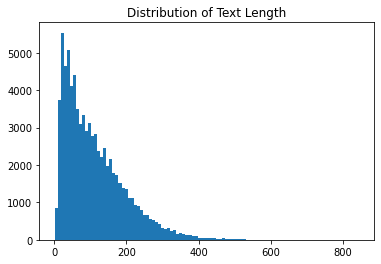

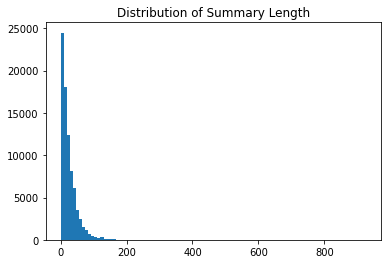

In [ ]:
plt.hist([len(t.split()) for t in train_df['FINDINGS']], bins = 100)
plt.title("Distribution of Text Length")
plt.show()

plt.hist([len(t.split()) for t in train_df['IMPRESSION']], bins = 100)
plt.title("Distribution of Summary Length")
plt.show()

In [ ]:
# Make into a data object
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

* Might need to add "[CLS]", end of sequence/sentence "[SEP]", padding
* need to remove odd characters
* encoding seems to be uncased. check if it has to be lower cased

function ClickConnect() {
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect, 60000)

In [ ]:
"""
finding_len = [len(x.split()) for x in train_df['FINDINGS']]
impression_len = [len(x.split()) for x in train_df['IMPRESSION']]

print("FINDINGS")
print(np.percentile(finding_len, [85, 90, 95]))
print("IMPRESSION")
print(np.percentile(impression_len, [85, 90, 95]))
print(np.percentile(impression_len, [5, 10, 15]))

FINDINGS
[197.15 228.   277.  ]
IMPRESSION
[45. 55. 71.]
[3. 5. 6.]
"""

FINDINGS
[197.15 228.   277.  ]
IMPRESSION
[45. 55. 71.]
[3. 5. 6.]


In [ ]:
"""
# Code to create the train set
full_df.drop_duplicates(['FINDINGS', 'IMPRESSION'], inplace = True)
joined_df = full_df.merge(test_df[['FINDINGS', 'IMPRESSION']], on = ['FINDINGS', 'IMPRESSION'], how = 'left', indicator = True)
train_set = joined_df[joined_df['_merge'] == 'left_only']
del train_set['_merge']
train_set.to_csv(path + 'train_set_rest.csv', index = False)
"""

"\n# Code to create the train set\nfull_df.drop_duplicates(['FINDINGS', 'IMPRESSION'], inplace = True)\njoined_df = full_df.merge(test_df[['FINDINGS', 'IMPRESSION']], on = ['FINDINGS', 'IMPRESSION'], how = 'left', indicator = True)\ntrain_set = joined_df[joined_df['_merge'] == 'left_only']\ndel train_set['_merge']\ntrain_set.to_csv(path + 'train_set_rest.csv', index = False)\n"